---
title: "ABC.12: Pixi and Desktop on genomeDK, R-clusterProfiler analysis"
author: "Dimitrios Maniatis"
image: ../img/news/clusterProfiler.png
date: 2025-01-30
categories: [GenomeDK, pixi, conda, package-environment, R, clusterProfiler, pathway-analysis]
description: "Pathway enrichment analysis with R package **clusterProfiler** "
eval: false
---

# Slides

Today we did not show slides for the topic presentation, but we went through the tutorial below.

# Tutorial

In this tutorial, we use clusterProfiler for pathway enrichment analysis in R. Pathway enrichment analysis is a method that identifies if a list of genes is over-represented in a pathway. There two widely popular methods for this, Over Reprentation Analysis(ORA) and Gene Set Enrichment Analysis. Both of these can be done by using clusterProfiler and both methods require a list of genes that are the output of a differential expression analysis. 
We will follow the examples presented by clusterProfiler here: https://yulab-smu.top/biomedical-knowledge-mining-book/enrichment-overview.html

We cover

- **Basic theory**: What are the issues with the test for enrichment, and what does the test means
- **Analysis**: How to use associated R packages to extrapolate pathway names connected to genes
- **Result and plots**: Viewing and reading the results correctly with beautiful plots



:::{.callout-warning}
You should be able to run the tutorial using the packages loaded in the R code below. Many of them are Bioconductor packages.
:::

In [1]:
#| output: false

library(clusterProfiler)
library(airway)
library(ggplot2)
library(dplyr)
library(DESeq2)
library(org.Hs.eg.db)
library(enrichplot)



clusterProfiler v4.14.0 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

S Xu, E Hu, Y Cai, Z Xie, X Luo, L Zhan, W Tang, Q Wang, B Liu, R Wang,
W Xie, T Wu, L Xie, G Yu. Using clusterProfiler to characterize
multiomics data. Nature Protocols. 2024, 19(11):3292-3320


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, co

## Over Representation Analysis (ORA)

**ORA** answers the question: "Which pathways are overrepresented in my list of significant genes?"

To answer this, we need a list of **background genes** (also referred to as the **universe**). This is important because overrepresentation is always relative, i.e. overrepresented **compared to what?** Therefore, we essentially create a **contingency table** to determine the significance of the pathway's representation in the gene list.e. For example:

In [2]:
mytable <- data.frame(not_interesting_genes=c(2613, 15310), interesting_genes=c(28, 29))
row.names(mytable) <- c("In pathway", "not in pathway")
mytable

,not_interesting_genes,interesting_genes
,<dbl>,<dbl>
In pathway,2613,28
not in pathway,15310,29


### Statistical Test
To determine over-representation, we use **Fisher's Exact Test**, which is a statistical test commonly applied in contingency table analysis. The test is represented by the following formula:

$$ p = 1 - \sum_{i=0}^{k-1} \frac{\binom{M}{i} \binom{N-M}{n-i}}{\binom{N}{n}} $$

Where:
- \( M \) is the total number of genes in the pathway,
- \( N \) is the total number of genes in the universe,
- \( n \) is the number of significant genes (those of interest),
- \( k \) is the number of significant genes in the pathway.


In [3]:
fisher.test(mytable, alternative = "greater")


	Fisher's Exact Test for Count Data

data:  mytable
p-value = 1
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 0.110242      Inf
sample estimates:
odds ratio 
 0.1767937 


Since we are testing multiple pathways we should correct for multiple testing. 

In [4]:
gene_data <- data.frame(
  Gene_Name = paste0("Gene", 1:10),
  LogFC = c(2.5, -1.2, 0.8, -2.3, 3.1, -0.5, 1.8, -1.0, 2.0, -3.0),
  P_value = c(0.001, 0.04, 0.2, 0.005, 0.0001, 0.3, 0.02, 0.06, 0.0005, 0.00001),
  Regulation = c("UP", "DOWN", "UP", "DOWN", "UP", "DOWN", "UP", "DOWN", "UP", "DOWN")
)

print(gene_data)


   Gene_Name LogFC P_value Regulation
1      Gene1   2.5   1e-03         UP
2      Gene2  -1.2   4e-02       DOWN
3      Gene3   0.8   2e-01         UP
4      Gene4  -2.3   5e-03       DOWN
5      Gene5   3.1   1e-04         UP
6      Gene6  -0.5   3e-01       DOWN
7      Gene7   1.8   2e-02         UP
8      Gene8  -1.0   6e-02       DOWN
9      Gene9   2.0   5e-04         UP
10    Gene10  -3.0   1e-05       DOWN


### ORA has some significant drawbacks. 

* Mainly it is highly dependent on what we (subjectively) will deem to be interesting genes. Usually that would be genes that are differentially expressed. 
* Additionally, it is highly dependent on the background genes. If there are lot of non annotated genes in the pathways then the power reduces substantially and also creates very biased results depending on which pathway databases you use.
* It does not take into account the combination of the p value and the logfc. What if a gene has a fold change of 5 but a p value of 0.051? 

## Gene Set Enrichment Analysis

These issues are addressed by Gene Set Enrichment analysis. **GSEA** answers the question "these changes I see between treatment and control are similar to which known list of changes". The big difference now is that instead of choosing a list of interesting genes we consider all the genes in the output of our degs analysis and we rank them! 

The core idea of Gene Set Enrichment Analysis (GSEA) is to assess whether the genes in a predefined gene set (e.g., a pathway) are enriched at the top or bottom of a ranked gene list.

1. Gene Ranking: Genes are ranked by a statistic, such as the log-fold change or p-value, representing their differential expression.

2. Enrichment Score (ES): The algorithm traverses the ranked gene list and computes a cumulative running score.
        When encountering a gene in the pathway, the score is increased proportionally to its rank.
        For genes not in the pathway, the score is decreased.
        The enrichment score (ES) is the maximum deviation from zero observed during this traversal.

3. Significance Testing: The observed ES is compared to a null distribution of ES values generated by permuting the gene labels. The significance is quantified as a p-value, and adjustments for multiple testing are applied.

4. Normalization: The ES is normalized (NES) to account for variations in gene set size, making results comparable across pathways.

Before we go any further lets quickly get a degs list using the airway package and deseq2

In [5]:
data(airway)
cts  <- assay(airway) # The counts matrix
metadata <- as.data.frame(colData(airway)) # Our metadata
metadata$condition <- factor(metadata$dex) # factor the dex col in condition
dds <- DESeqDataSetFromMatrix(
  countData = cts,
  colData = metadata,
  design = ~ condition
)
dds <- DESeq(dds)
res <- results(dds)
resdf <- as.data.frame(res)
head(res)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition untrt vs trt 
Wald test p-value: condition untrt vs trt 
DataFrame with 6 rows and 6 columns
                  baseMean log2FoldChange     lfcSE      stat    pvalue
                 <numeric>      <numeric> <numeric> <numeric> <numeric>
ENSG00000000003 708.602170      0.3788470  0.173141  2.188082 0.0286636
ENSG00000000005   0.000000             NA        NA        NA        NA
ENSG00000000419 520.297901     -0.2037604  0.100599 -2.025478 0.0428183
ENSG00000000457 237.163037     -0.0340428  0.126279 -0.269584 0.7874802
ENSG00000000460  57.932633      0.1171786  0.301237  0.388992 0.6972820
ENSG00000000938   0.318098      1.7245505  3.493633  0.493627 0.6215698
                     padj
                <numeric>
ENSG00000000003  0.139308
ENSG00000000005        NA
ENSG00000000419  0.183359
ENSG00000000457  0.930572
ENSG00000000460  0.895441
ENSG00000000938        NA

Now we can rank the list. There is not on a correct way to rank the gene lists but we would like the ranking to represent both the significance and the fold change. One suggested formula is: 

$$
\text{Ranking Score} = \log_{2}(\text{Fold Change}) \times -\log_{10}(\text{P-value})
$$

Additionally we can order them by the stat column of the deseq2 output which is the wald statistic. This creates a list where over expressed and significant genes are at the top, under expressed and significant genes in the bottom and combinations of not significant genes in the middle.

In [6]:
resOrdered <- res[order(res$stat),] 

# Cluster Profiler examples

**clusterProfiler** makes it easy to perform both ORA and GSEA analyses. It uses two main functions in the background:
* **`enricher()`** (for ORA)
* **`GSEA()`** (for GSEA)
  
These two allow you to submit your own pathways via the TERM2GENE parameter. For example

In [7]:
TERM2GENE <- data.frame(
  TERM = c("GO:0005737", "GO:0008150", "KEGG:04110"),
  GENE = c("gene1, gene2, gene3", "gene4, gene5, gene6", "gene7, gene8")
)
# Example
#enricher(gene_list, TERM2GENE = TERM2GENE)

### Curated Pathway Lists

ClusterProfiler also has built-in support for curated lists of pathways, such as **KEGG** and **GO**. These are already implemented in the following functions:

1. **`enrichKEGG`**: Enrichment analysis for **KEGG** pathways.
2. **`enrichGO`**: Enrichment analysis for **Gene Ontology (GO)** terms.
3. **`gseGO()`**: GSEA for **Gene Ontology (GO)** terms.
4. **`gseKEGG`**: GSEA for **KEGG** pathways.


Now lets see some examples for GO. For ORA we will use the examples from the guide

In [8]:
data(geneList, package="DOSE")
gene <- names(geneList)[abs(geneList) > 2] # Create our list of significant genes
ego <- enrichGO(gene          = gene, # Our genelist
                universe      = names(geneList), # The background universe we talked about
                OrgDb         = org.Hs.eg.db, # Our database 
                ont           = "CC", # The Gene Ontology
                pAdjustMethod = "BH", # Correction for multiple testint
                pvalueCutoff  = 0.01, # Our cutoffs
                qvalueCutoff  = 0.05,
        readable      = TRUE) # SetReadable converts the genes to SYMBOL automatically. Very handy.
head(ego)

,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0000775,GO:0000775,"chromosome, centromeric region",21/201,199/11919,0.10552764,6.257631,9.795483,1.849874e-11,5.272141e-09,4.829145e-09,CDCA8/CDC20/CENPE/NDC80/TOP2A/HJURP/SKA1/NEK2/CENPM/CENPN/ERCC6L/MAD2L1/KIF18A/CDT1/BIRC5/EZH2/TTK/NCAPG/AURKB/AURKA/CCNB1,21
GO:0000779,GO:0000779,"condensed chromosome, centromeric region",18/201,148/11919,0.12162162,7.211981,9.959264,5.132324e-11,5.985415e-09,5.482485e-09,CDC20/CENPE/NDC80/HJURP/SKA1/NEK2/CENPM/CENPN/ERCC6L/MAD2L1/KIF18A/CDT1/BIRC5/TTK/NCAPG/AURKB/AURKA/CCNB1,18
GO:0072686,GO:0072686,mitotic spindle,18/201,152/11919,0.11842105,7.022192,9.786254,8.053824e-11,5.985415e-09,5.482485e-09,KIF23/CENPE/ASPM/DLGAP5/SKA1/NUSAP1/TPX2/TACC3/CDK1/MAD2L1/KIF18A/KIF11/TRAT1/AURKB/PRC1/KIFC1/KIF18B/AURKA,18
GO:0005819,GO:0005819,spindle,26/201,338/11919,0.07692308,4.561424,8.699252,8.806167e-11,5.985415e-09,5.482485e-09,CDCA8/CDC20/KIF23/CENPE/ASPM/DLGAP5/SKA1/NUSAP1/TPX2/TACC3/NEK2/CDK1/MAD2L1/KIF18A/BIRC5/KIF11/TRAT1/TTK/AURKB/PRC1/KIFC1/KIF18B/KIF20A/AURKA/CCNB1/KIF4A,26
GO:0000793,GO:0000793,condensed chromosome,21/201,219/11919,0.09589041,5.686158,9.166827,1.142683e-10,5.985415e-09,5.482485e-09,CDC20/CENPE/NDC80/TOP2A/NCAPH/HJURP/SKA1/NEK2/CENPM/CENPN/ERCC6L/MAD2L1/KIF18A/CDT1/BIRC5/TTK/NCAPG/AURKB/CHEK1/AURKA/CCNB1,21
GO:0098687,GO:0098687,chromosomal region,25/201,319/11919,0.07836991,4.647218,8.647710,1.406548e-10,5.985415e-09,5.482485e-09,CDCA8/CDC20/CENPE/NDC80/TOP2A/HJURP/SKA1/NEK2/CENPM/RAD51AP1/CENPN/CDK1/ERCC6L/MAD2L1/KIF18A/CDT1/BIRC5/EZH2/TTK/NCAPG/AURKB/CHEK1/AURKA/CCNB1/MCM5,25


Similarly we can to **GSEA**. Here we set min and max gene set sizes because gene sets that are too small might not have enough data for reliable statistical analysis, while very large gene sets may not provide useful biological insights because they tend to be too broad. Your call.

In [9]:
ego3 <- gseGO(geneList     = geneList, # Here we have all the genes
              OrgDb        = org.Hs.eg.db, # Our database
              ont          = "CC",
              minGSSize    = 100, # This is the minimum gene set size
              maxGSSize    = 500, # Maximum geneset size
              pvalueCutoff = 0.05,
              verbose      = FALSE)

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”


### Gene Ontology (GO)
Gene Ontology (GO) categorizes genes into three domains:

* **Biological Process (BP)**: The biological objectives or processes in which the gene products are involved (e.g., cell cycle, metabolic processes).
* **Molecular Function (MF)**: The molecular activities performed by gene products (e.g., enzyme activity, receptor binding).
* **Cellular Component (CC)**: The locations within the cell where gene products are found (e.g., nucleus, mitochondria).

### KEGG Pathways
KEGG (Kyoto Encyclopedia of Genes and Genomes) provides a comprehensive database of **metabolic** and **signaling pathways** that help identify biological functions and interactions.

### Other Databases
- **MsigDB**: A Molecular Signature Database that is particularly useful for performing GSEA.
- **Reactome**: A curated pathway database for functional annotation of genes, focusing on human pathways.

## Plots

One of the great things about clusterProfiler is that you can very easily create plots with the <span style="color: orange;">`enrichplot`</span> library and they are very well integrated with ggplot. Here we will show some of them as there are many. You can see more here:
https://yulab-smu.top/biomedical-knowledge-mining-book/enrichplot.html

### Converting Gene Lists

When working with gene lists, it's often necessary to convert between different types of gene identifiers. For instance, you may need to convert between **ENTREZID**, **ENSEMBL**, and **SYMBOL** identifiers, which are commonly used in gene annotation databases. The **bitr()** function from the **clusterProfiler** package is a useful tool for this task.

In [10]:
bitr(gene, fromType = "ENTREZID",
        toType = c("ENSEMBL", "SYMBOL"),
        OrgDb = org.Hs.eg.db)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(gene, fromType = "ENTREZID", toType = c("ENSEMBL", "SYMBOL"), :
“0.48% of input gene IDs are fail to map...”


,ENTREZID,ENSEMBL,SYMBOL
,<chr>,<chr>,<chr>
1,4312,ENSG00000196611,MMP1
2,8318,ENSG00000093009,CDC45
3,10874,ENSG00000109255,NMU
4,55143,ENSG00000134690,CDCA8
5,55388,ENSG00000065328,MCM10
6,991,ENSG00000117399,CDC20
7,6280,ENSG00000163220,S100A9
8,2305,ENSG00000111206,FOXM1
9,9493,ENSG00000137807,KIF23


Lets see from our examples:

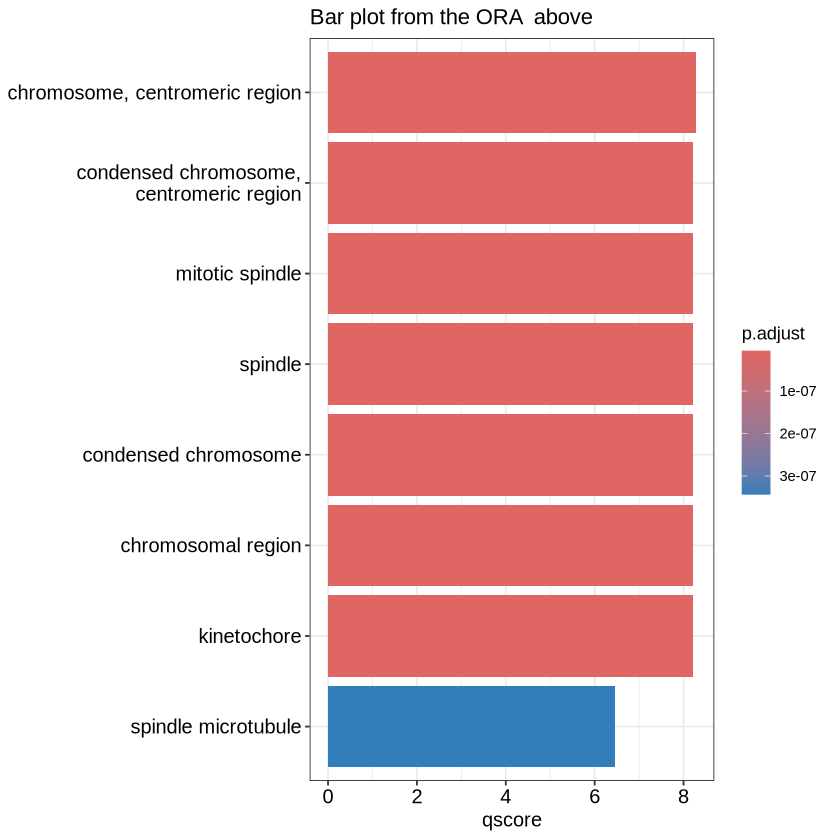

In [11]:
mutate(ego, qscore = -log(p.adjust, base=10)) %>% 
    barplot(x="qscore") + ggtitle("Bar plot from the ORA  above")

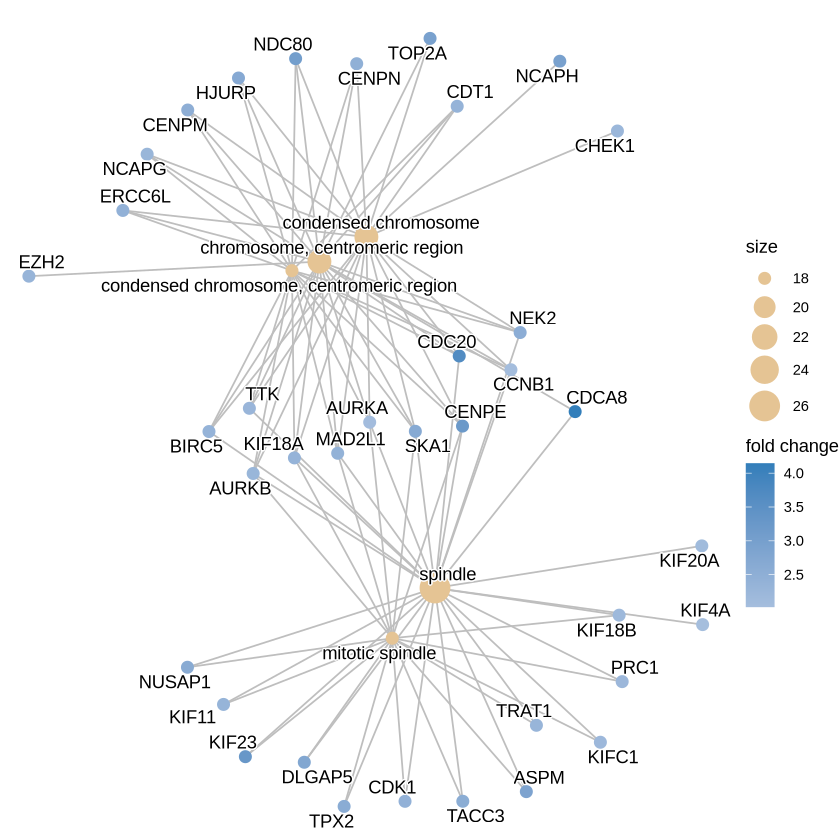

In [12]:
edox <- setReadable(ego, 'org.Hs.eg.db', 'ENTREZID') # Convert to symbol
p <- cnetplot(edox, foldChange=geneList, circular = TRUE, colorEdge = TRUE)
p

A very informative plot is a heatplot which you can generate like this:

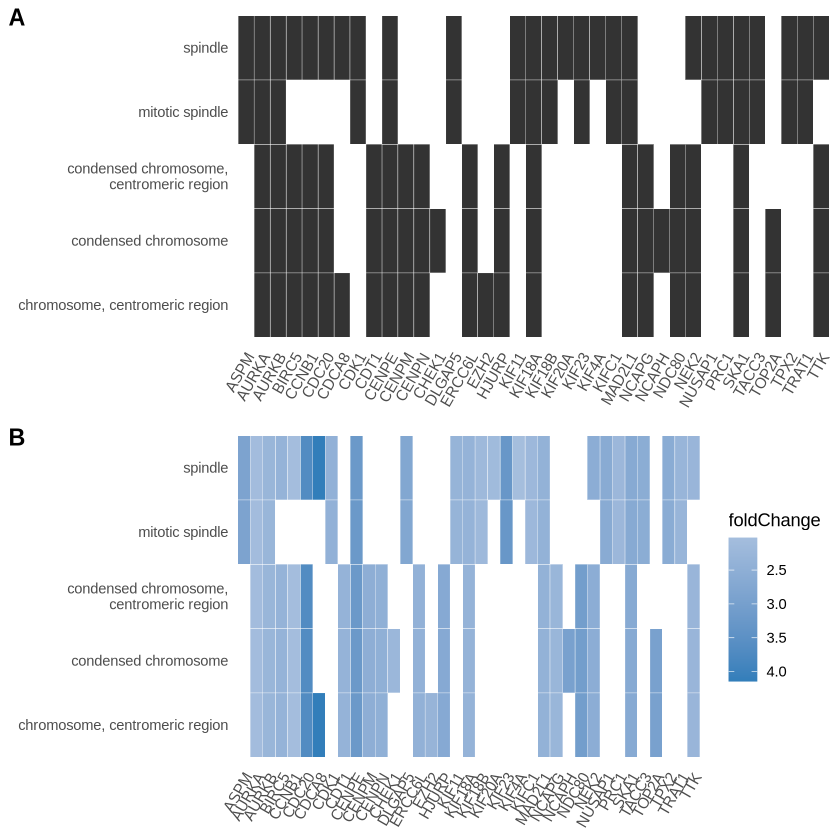

In [13]:
p1 <- heatplot(edox, showCategory=5) # Show category dictates show many genesets you see
p2 <- heatplot(edox, foldChange=geneList, showCategory=5)
cowplot::plot_grid(p1, p2, ncol=1, labels=LETTERS[1:2])

One of the most useful ones I find to be the upset plot. For over-representation analysis, upsetplot will calculate the overlaps among different gene sets and for GSEA result, it will plot the fold change distributions of different categories.

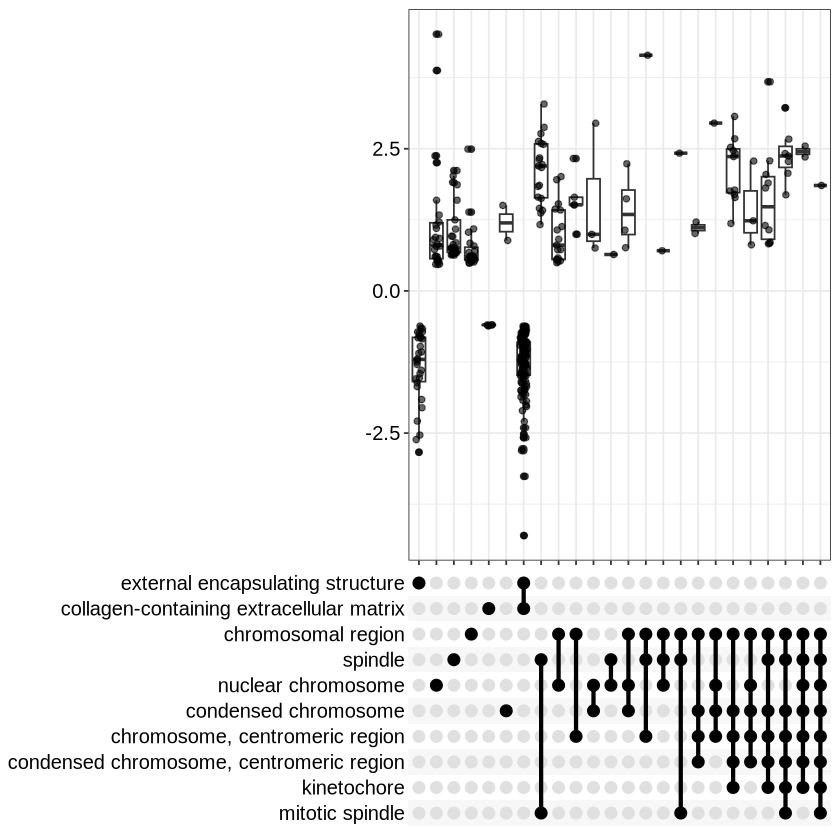

In [18]:
upsetplot(ego3) 

Picking joint bandwidth of 0.223



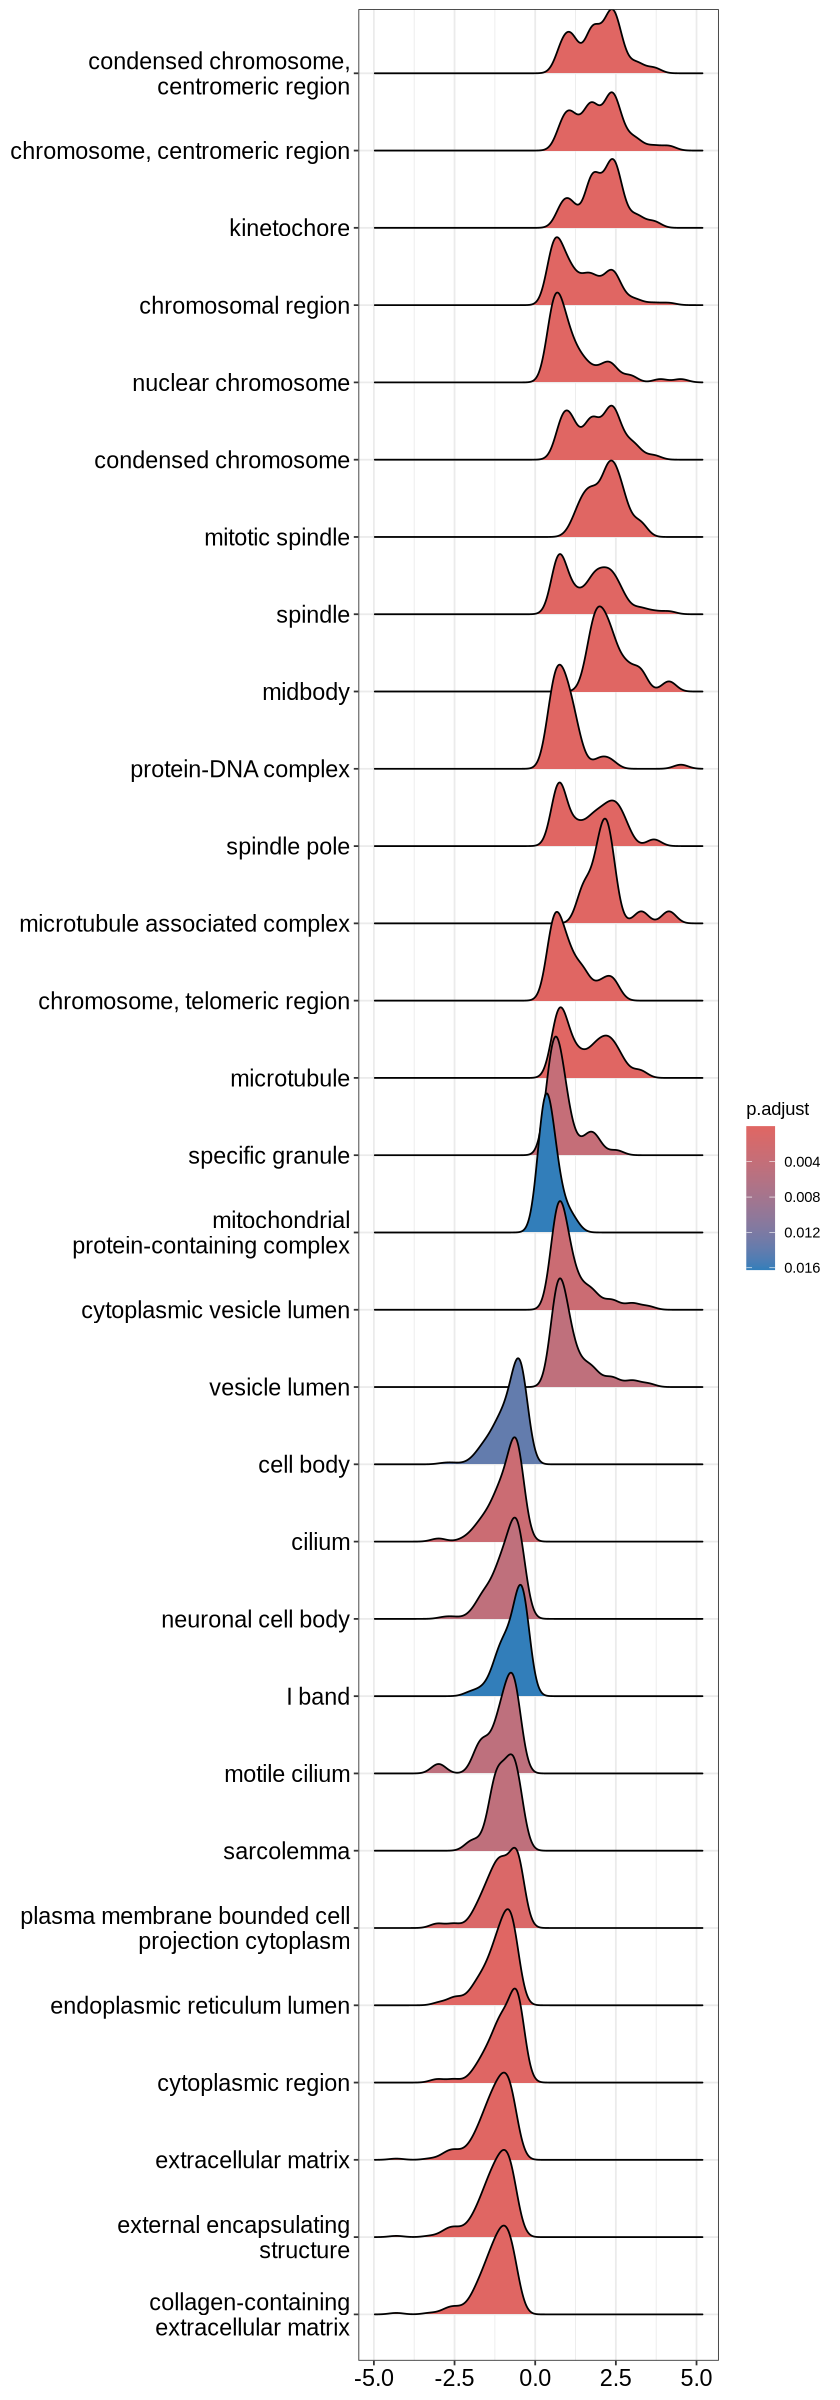

In [26]:
options(repr.plot.height=20)
ridgeplot(ego3)

Lastly we have: Running score and preranked list are traditional methods for visualizing the results of Gene Set Enrichment Analysis (GSEA). These visualizations help to understand how a particular gene set is enriched along the ordered gene list, as well as how the enrichment score changes as you progress through the gene list.

In [27]:
p1 <- gseaplot(ego3, geneSetID = 1, by = "runningScore", title = ego3$Description[1])
p2 <- gseaplot(ego3, geneSetID = 1, by = "preranked", title = ego3$Description[1])

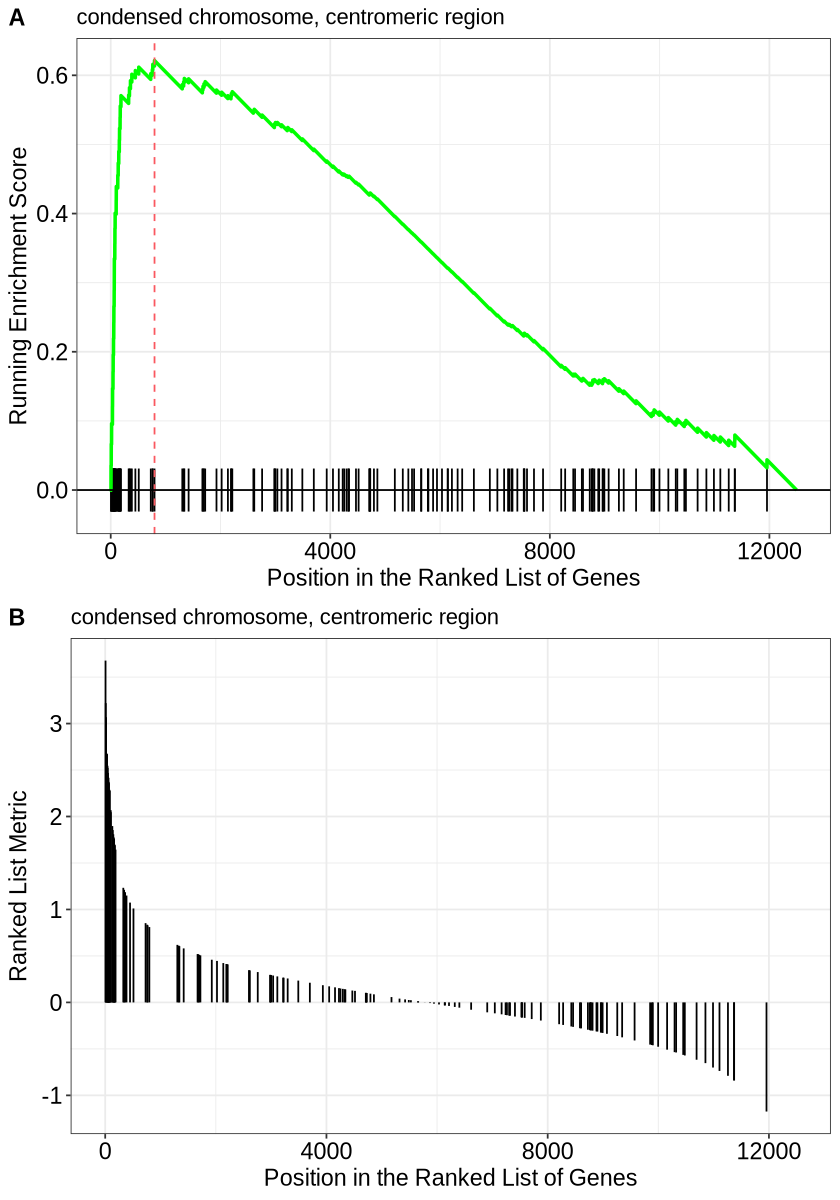

In [29]:
options(repr.plot.height=10)
cowplot::plot_grid(p1, p2, ncol=1, labels=LETTERS[1:3])

### Running Score Plot Interpretation

The running score plot illustrates how the enrichment score (ES) accumulates as you move through the ranked gene list. The key features to observe are:

*    Sharp Peaks: A sharp rise indicates that a cluster of genes from the pathway is highly ranked, contributing strongly to enrichment.
*    Peak Position: The x-axis location of the peak corresponds to where the pathway’s genes are most enriched within the ranked list.
*    Running Score Return: If the score drops back down, it suggests that the pathway genes are not uniformly distributed across the gene list.